In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
from torch import optim
from torchvision.datasets import MNIST
from torchvision import transforms as T
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
mnist_train = MNIST("/kaggle/working", train=True, download=True, transform=T.ToTensor())
mnist_valid = MNIST("/kaggle/working", train=False, download=True, transform=T.ToTensor())

In [3]:
train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
valid_loader = DataLoader(mnist_valid, batch_size=64, shuffle=False)

In [4]:
class Conv_Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5)
        self.conv2 =  nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5)
        
        self.activation = nn.ReLU()
        self.maxpool =  nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(4 * 4 * 128, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        output = self.activation(self.conv1(x)) # 64*24*24
        output = self.maxpool(output) # 64*12*12
        output = self.activation(self.conv2(output)) # 128*8*8
        output = self.maxpool(output) # 128*4*4
        output = self.flatten(output)
        output = self.activation(self.fc1(output))
        output = self.activation(self.fc2(output))
        output = self.activation(self.fc3(output))
        output = self.fc4(output)


        return output

In [5]:
conv_model = Conv_Model()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(conv_model.parameters(), lr=1e-3)

In [6]:
def train(model: nn.Module) -> float:
    model.train()
    loss_hist = []
    
    for x, y in tqdm(train_loader, desc='Train'):
        optimizer.zero_grad()
        output = model(x)
        loss = loss_fn(output, y)
        loss_hist.append(loss.item())
        loss.backward()
        optimizer.step()
        
    return np.mean(loss_hist)   

In [7]:
@torch.inference_mode()
def evaluate(model: nn.Module, loader: DataLoader) -> tuple[float, float]:
    model.eval()
    loss_hist = []
    total = 0
    correct = 0
    
    for x, y in tqdm(loader, desc='Valid'):
        output = model(x)
        loss = loss_fn(output, y)
        loss_hist.append(loss.item())
        _, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (y==y_pred).sum().item()
        
    return np.mean(loss_hist), correct/total    

In [8]:
def plot_stat(train_loss: list[float], valid_loss: list[float], accuracy: list[float], title: str):
    plt.figure(figsize=(16, 8))
    plt.title(title + ' loss')
    
    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()
    plt.show()
    
    plt.figure(figsize=(16, 8))
    plt.title(title + ' valid accuracy')
    plt.plot(accuracy)
    plt.legend()
    plt.grid()
    plt.show()

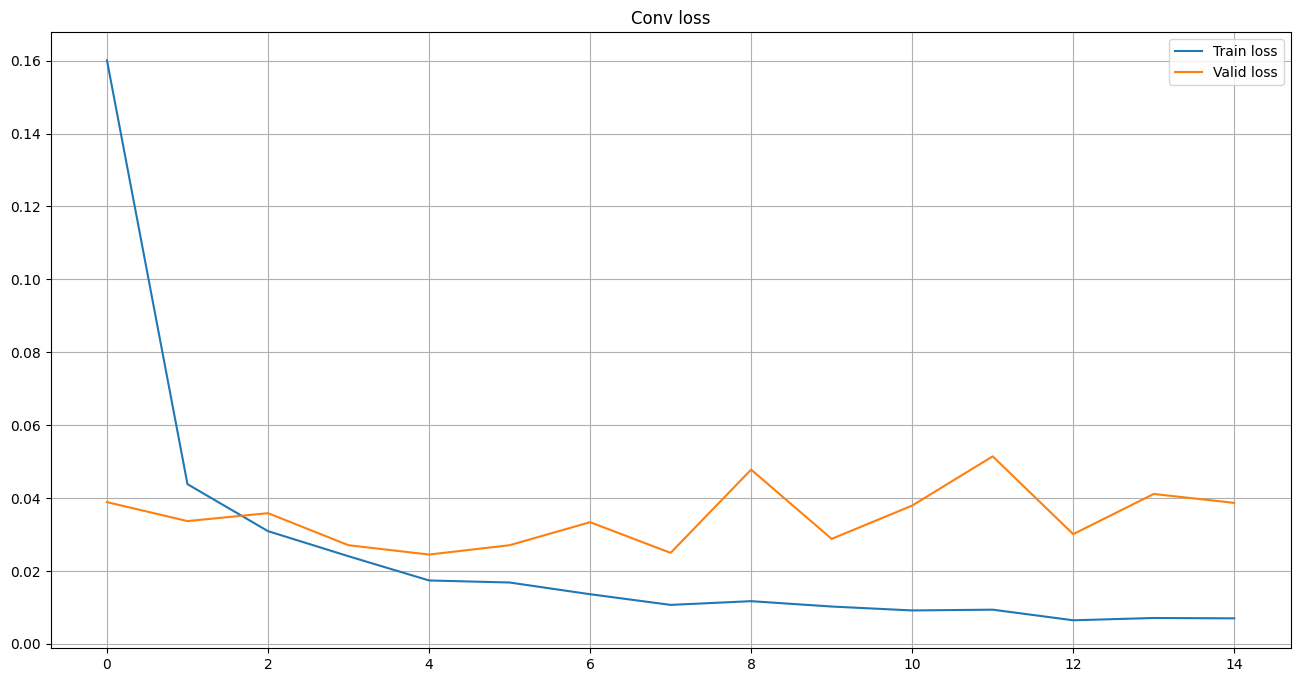

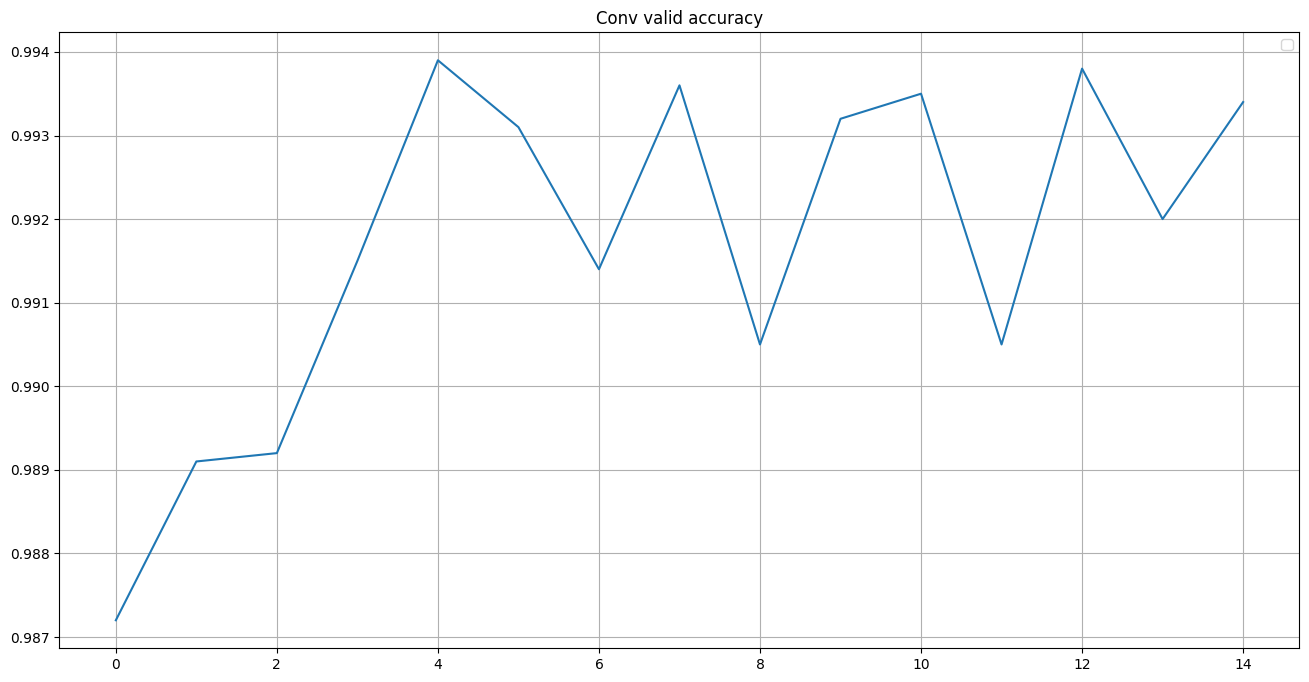

Valid accuracy: 0.9934


In [9]:
num_epochs = 15
train_hist_loss = []
valid_hist_loss = []
accuracy_hist_loss = []

for epoch in range(num_epochs):
    train_loss = train(conv_model)
    train_hist_loss.append(train_loss)
    valid_loss, acc = evaluate(conv_model, valid_loader)
    valid_hist_loss.append(valid_loss)
    accuracy_hist_loss.append(acc)
    
    clear_output()
    
    plot_stat(train_hist_loss, valid_hist_loss, accuracy_hist_loss, 'Conv')
    
    if epoch==(num_epochs-1):
        print(f'Valid accuracy: {accuracy_hist_loss[-1]}')

In [10]:
torch.save(conv_model.state_dict(), "conv_model_weight.pt")